In [19]:

import numpy as np
import os
import pandas as pd
import pickle
import sys
sys.path.append('..')
from src.tools import numerai_api, utils

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
%matplotlib inline


In [2]:
import logging
# setup logger
log_fmt = '%(asctime)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout

In [3]:
df = utils.load_data()

2018-02-10 18:29:18,045 - INFO - Getting raw data
2018-02-10 18:29:18,326 - INFO - Downloading data for round 94
2018-02-10 18:30:35,801 - INFO - Download finished, unzipping into dataframe
2018-02-10 18:30:42,884 - INFO - Data unzipped, concatenating into one dataframe
2018-02-10 18:30:43,071 - INFO - Data concatenated, downcasting data
2018-02-10 18:30:43,071 - INFO - Downcasting features to float32
2018-02-10 18:30:47,735 - INFO - Converting era to numeric
2018-02-10 18:31:00,871 - INFO - Downcasting era and target to integers
2018-02-10 18:31:01,042 - INFO - Data converted, saving to file
2018-02-10 18:31:02,618 - INFO - Dataset for round 94 downloaded as 94_numerai_raw.pkl


In [11]:
round_number = numerai_api.get_current_round()
print('Current round number:', round_number)

Current round number: 94


In [4]:
df_prediction = df.loc[(df['data_type'] == 'validation') | 
                       (df['data_type'] == 'test') | 
                       (df['data_type'] == 'live'), 'feature1':'feature50']

df_validation_predict = df.loc[df['data_type'] == 'validation','feature1':'feature50']
df_validation_target = df.loc[df['data_type'] == 'validation','target']

X_train_era = df.loc[df['data_type'] == 'train', :].drop(['data_type','target'], axis=1)
y_train_era = df.loc[df['data_type'] == 'train', ['era','target']]

X_train = X_train_era.drop('era', axis=1)
y_train = y_train_era['target']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000079C53B70>,
        ...,
        ...,
        ...,
       ...,
        ...,
        ...,
        ...,
      dtype=object)

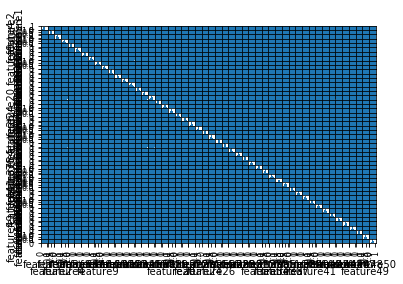

In [75]:
pd.plotting.scatter_matrix(X_train.loc[:,'feature1':'feature50'])

In [76]:
scatter = Out[75]

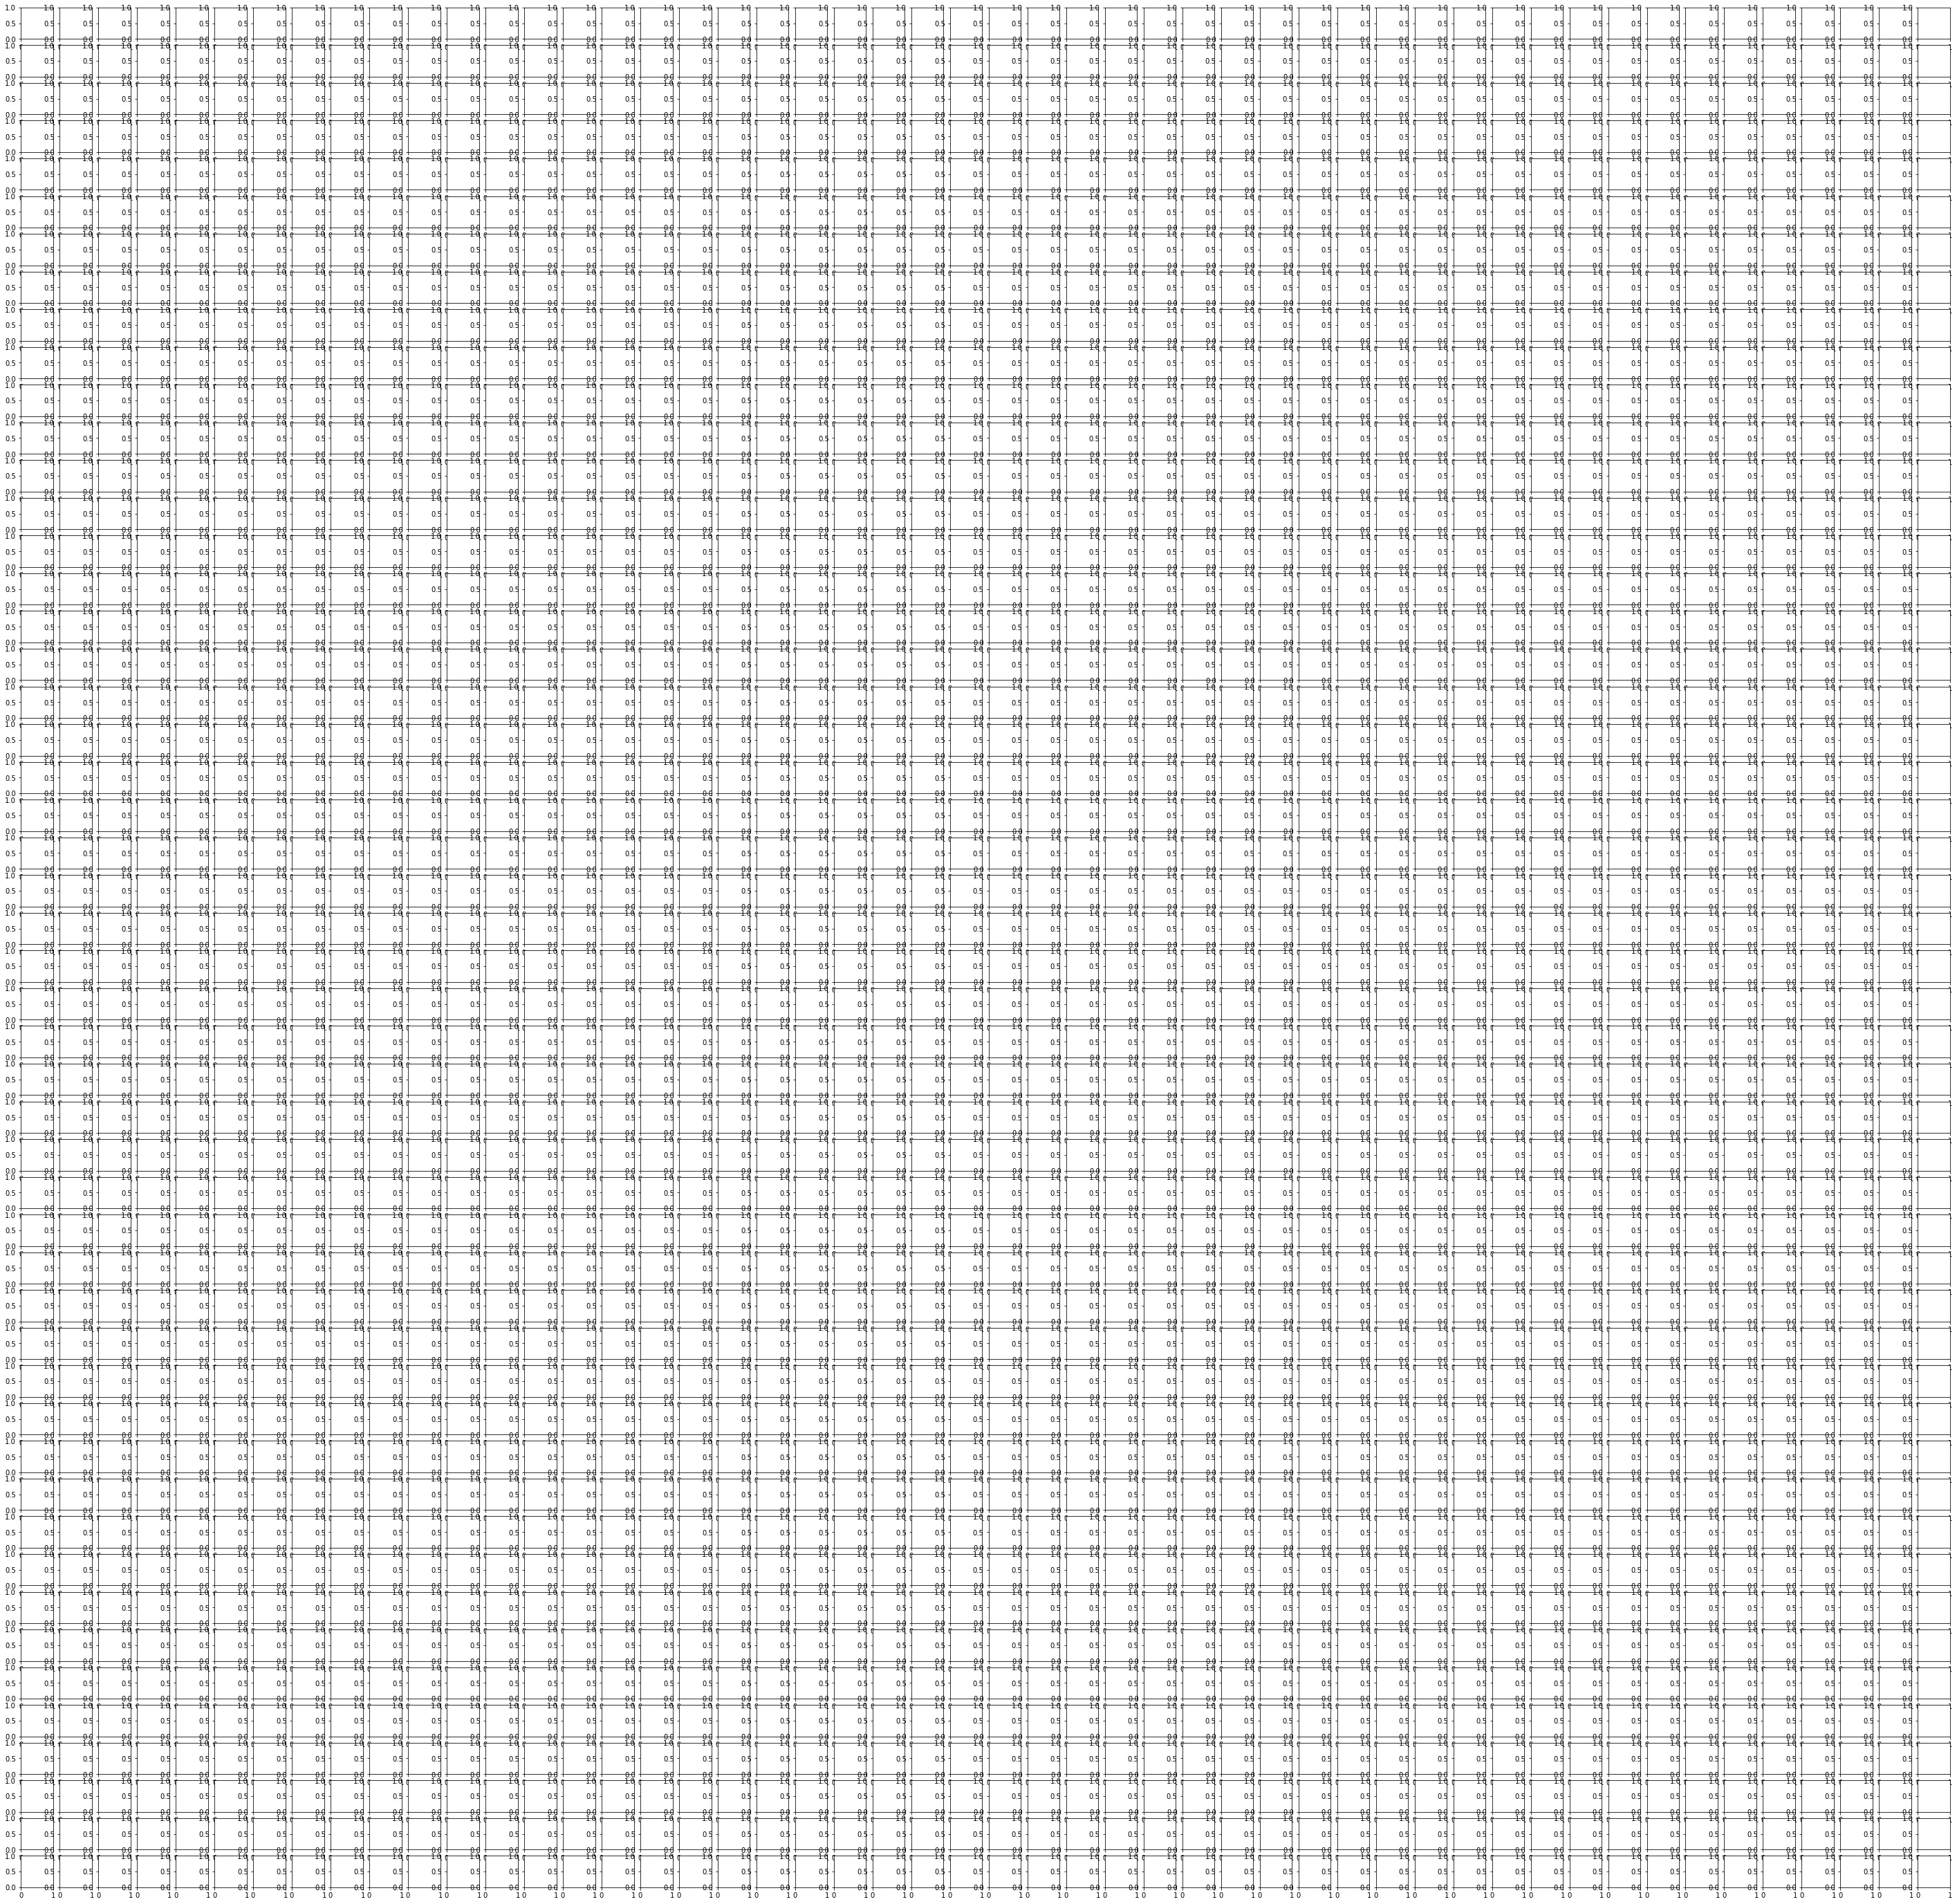

In [85]:
numvars, numdata = scatter.shape
fig, axes = plt.subplots(nrows=numvars, ncols=numvars, figsize=(50,50))

In [86]:
for ax in axes.flat:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    if ax.is_first_col():
        ax.yaxis.set_ticks_position('left')
    if ax.is_last_col():
        ax.yaxis.set_ticks_position('right')
    if ax.is_first_row():
        ax.xaxis.set_ticks_position('top')
    if ax.is_last_row():
        ax.xaxis.set_ticks_position('bottom')    
        
for i, j in zip(*np.triu_indices_from(axes, k=1)):
    for x, y in [(i,j), (j,i)]:
        axes[x,y].plot(data[x], data[y], **kwargs)

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')

    # Turn on the proper x or y axes ticks.
    for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
        axes[j,i].xaxis.set_visible(True)
        axes[i,j].yaxis.set_visible(True)
        
        
plt.show()       

NameError: name 'data' is not defined

The following is done with cross_val_score

for i in range(0,10):
    
    log_reg_model.fit(X_split_train[i].drop('era', axis=1), y_split_train[i]['target'])
    score = log_reg_model.score(X_split_test[i].drop('era', axis=1), y_split_test[i]['target'])
    print(score)

In [6]:
lg = LogisticRegression()
gkf = GroupKFold(n_splits=10)
cv = gkf.split(X_train_era, y_train_era, groups=X_train_era['era'])
#cv_log_loss = cross_val_score(lg, X_train.drop('era', axis=1), y_train['target'], cv=cv, scoring='neg_log_loss') 

In [5]:
def create_submission(df_predict_feat, model, filename='predictions.csv', filter_=np.empty(0)):
    submission = pd.DataFrame()
    submission['id'] = df_predict_feat.index
    
    if filter_.any():
        df_predict_feat = df_predict_feat.drop(df_predict_feat.columns[filter_], axis=1)
    submission['probability'] = model.predict_proba(df_predict_feat)[:,1]
    submission.to_csv(filename,index=None)

In [6]:
def get_validation_log_loss(model, df, filter_=np.empty(0)):
    df_validation_predict = df.loc[df['data_type'] == 'validation','feature1':'feature50']
    if filter_.any():
        df_validation_predict = df_validation_predict.drop(df_validation_predict.columns[filter_], axis=1)
    
    df_validation_target = df.loc[df['data_type'] == 'validation','target']
    validation_prediction = model.predict_proba(df_validation_predict)
    return log_loss(df_validation_target, validation_prediction)

def check_consistency(model, df, filter_=np.empty(0)):
    eras_passed=0
    for era in df.loc[df['data_type']=='validation',:].era.unique():
        loss = get_validation_log_loss(model,df.loc[df['era']==era,:],filter_)
        if loss < 0.693:
            eras_passed+=1

    return eras_passed/12



In [33]:
lg_baseline = LogisticRegression(random_state=21)
logger.info('Fitting model')
lg_baseline.fit(X_train, y_train)
logger.info('Model fit')

create_submission(df_prediction, lg_baseline, 'predictions_baseline.csv')
baseline_logloss = get_validation_log_loss(lg_baseline, df)
baseline_logloss

2018-01-31 16:14:41,187 - INFO - Fitting model
2018-01-31 16:14:54,863 - INFO - Model fit


0.692945879397903

In [36]:

scaler = preprocessing.MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
validation_features_scaled = scaler.transform(df.loc[df['data_type']=='validation','feature1':'feature50'])

lg_scaled = LogisticRegression(n_jobs=-1, solver='saga', random_state=21)
logger.info('Fitting model')
lg_scaled.fit(X_train_scaled, y_train)
logger.info('Model fit')

validation_target = df.loc[df['data_type'] == 'validation','target']
validation_prediction = lg_scaled.predict_proba(validation_features_scaled)
lg_scaled_logloss = log_loss(validation_target, validation_prediction)
lg_scaled_logloss

2018-01-31 16:16:22,163 - INFO - Fitting model
2018-01-31 16:16:33,231 - INFO - Model fit


0.6929470574555433

In [ ]:
lg_important_features = np.where(abs(lg_baseline.coef_) > .2)

0.692945879397903 baseline 
0.6929555810479051 standard scaled 
0.6929555168509783 robust scaled
0.6929470574555433 max abs scaled




In [ ]:
lg_opt = LogisticRegression(n_jobs=-1, random_state=21, 
                            penalty='l1')
logger.info('Fitting model')
lg_opt.fit(X_train, y_train)
logger.info('Model fit')

lg_opt_logloss = get_validation_log_loss(lg_opt, df)
lg_opt_logloss

2018-01-31 15:39:51,440 - INFO - Fitting model


In [30]:
cv = gkf.split(X_train_era, y_train_era, groups=X_train_era['era'])
lg_group = LogisticRegressionCV(cv=cv)
logger.info('Starting model fit')
lg_group.fit(X_train, y_train)
logger.info('Model fitted')
group_logloss = get_validation_log_loss(lg_group, df)
group_logloss

2018-01-28 11:03:17,990 - INFO - Starting model fit
2018-01-28 11:06:18,937 - INFO - Model fitted


In [32]:
(group_logloss-baseline_logloss)/group_logloss*100

-0.05782708551779613

In [18]:
print(0.6926237830311198 - 0.6926199800815499)
print(0.6926199800815499 - 0.6926260055809711)

3.802949569919889e-06
-6.025499421191682e-06


0.7809569239067203 default
0.6926539978867465 n_estimators=1000,max_leaf_nodes=15
0.6926281272932799 n_estimators=500,max_leaf_nodes=15
0.6984105280907695 n_estimators=100,max_leaf_nodes=None
0.6928226448632782 n_estimators=100,max_leaf_nodes=5

0.6926490053669208 n_estimators=50,max_leaf_nodes=15
0.6926264881596373 n_estimators=100,max_leaf_nodes=15
0.6926237830311198 n_estimators=150,max_leaf_nodes=15
0.6926199800815499 n_estimators=175,max_leaf_nodes=15
0.6926260055809711 n_estimators=200,max_leaf_nodes=15


0.6925970274264839 n_estimators=175,max_leaf_nodes=20
0.6925456965520028 n_estimators=175,max_leaf_nodes=30
0.6925077743059121 n_estimators=175,max_leaf_nodes=50
0.6924796040625568 n_estimators=175,max_leaf_nodes=100
0.6924269351737405 n_estimators=175,max_leaf_nodes=150
0.6923994850550886 n_estimators=175,max_leaf_nodes=200
0.692395593293289  n_estimators=175,max_leaf_nodes=205
0.6924060245108058 n_estimators=175,max_leaf_nodes=210
0.6924183696339382 n_estimators=175,max_leaf_nodes=225
0.6924205980793621 n_estimators=175,max_leaf_nodes=250
0.6924420819324049 n_estimators=175,max_leaf_nodes=300
0.692472160869273  n_estimators=175,max_leaf_nodes=400


0.6924482343001823 n_estimators=175,max_leaf_nodes=205 entropy

0.6925234826212867 n_estimators=175,max_leaf_nodes=205,max_features=log2
0.692395593293289  n_estimators=175,max_leaf_nodes=205
0.6924785583536479 n_estimators=175,max_leaf_nodes=205,max_features=8
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10
0.6924414990011737 n_estimators=175,max_leaf_nodes=205,max_features=11
0.692452599084798  n_estimators=175,max_leaf_nodes=205,max_features=12
0.692434921786358  n_estimators=175,max_leaf_nodes=205,max_features=15
0.6924986626987714 n_estimators=175,max_leaf_nodes=205,max_features=20
0.6925193101183662 n_estimators=175,max_leaf_nodes=205,max_features=30
0.6924359465554766 n_estimators=175,max_leaf_nodes=205,max_features=50

0.6924264481698214 n_estimators=175,max_leaf_nodes=205,max_features=10, bootstrap=False
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10, oob_score=True

0.6924813705374833 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=5
0.6924325504443605 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=10
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=50
0.6923830374594487 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=30
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=40
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=35
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=32
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10,max_depth=31

0.6924227331958277 n_estimators=175,max_leaf_nodes=205,max_features=10,min_samples_split=0.01
0.6923817293453017 n_estimators=175,max_leaf_nodes=205,max_features=10,min_samples_split=3
0.6924284376896439 n_estimators=175,max_leaf_nodes=205,max_features=10,min_samples_split=50
0.6923971988691803 n_estimators=175,max_leaf_nodes=205,max_features=10,min_samples_split=20
0.6924490732428077 n_estimators=175,max_leaf_nodes=205,max_features=10,min_samples_split=10

0.6922934463211274 top 15 max 10
0.6930808753582083 top 4
0.69265250301624   top 7 no max features
0.6924978160188072 top 11
0.6923629534794612 top 22 max 10
0.6923870823834799 top 22 no max features
0.6923336618872348 top 19 max 10
0.6923747980103881 top 17 max 10
0.6923650167342608 top 16 max 10
0.6923704226959646 top 14

0.6922934463211274 top 15 max 10
0.6922937527006087 max abs scaler
0.6922938995815806 robust scaler
0.692294168860375  standard scaler
0.6922932509521263 standard no mean

0.6922837586171385

0.6924052073894894 PCA reduction to 7
0.6923661805741801 PCA reduction to 
0.6923270568188112


In [7]:
rfc_baseline = RandomForestClassifier(n_jobs=-1,
                             n_estimators=170, 
                             max_leaf_nodes=203,
                             max_features=10,
                             random_state=21)

logger.info('Starting model fit')
rfc_baseline.fit(X_train, y_train)
logger.info('Model fitted')

rfc_baseline_logloss = get_validation_log_loss(rfc_baseline, df)
rfc_baseline_logloss

2018-02-10 18:31:03,523 - INFO - Starting model fit
2018-02-10 18:33:19,279 - INFO - Model fitted


0.6924540348565935

In [13]:
rfc_baseline_file = 'rfc_baseline_{}.pkl'.format(round_number)
pickle.dump(rfc_baseline, open(rfc_baseline_file,'wb'))

In [52]:
rfc_baseline.feature_importances_



array([0.02118872, 0.01855285, 0.0163316 , 0.01661723, 0.01622318,
       0.0265565 , 0.02042933, 0.01947872, 0.02156138, 0.01802081,
       0.0243686 , 0.01773891, 0.01841531, 0.0181934 , 0.02461668,
       0.02075498, 0.02115975, 0.01722547, 0.01758764, 0.01861885,
       0.01953899, 0.01627756, 0.01519622, 0.01773765, 0.02333991,
       0.01707606, 0.0193505 , 0.02822442, 0.01880013, 0.01694741,
       0.04367985, 0.01849128, 0.0180375 , 0.02608817, 0.01656674,
       0.02645637, 0.0202658 , 0.01618014, 0.01908188, 0.01551571,
       0.02337935, 0.02465134, 0.01540788, 0.01587447, 0.01655476,
       0.02799555, 0.01699204, 0.01696695, 0.01835103, 0.01733443])

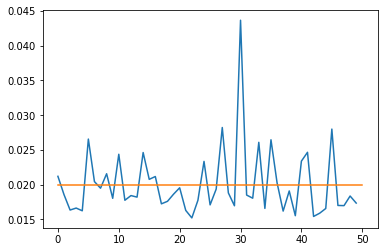

In [71]:
even_importance = 1/len(rfc_baseline.feature_importances_)
plt.plot(rfc_baseline.feature_importances_)
plt.plot([0,50],[even_importance,even_importance])
plt.show()

In [70]:
rfc_baseline = pickle.load(open(rfc_baseline_file,'rb'))
filter_ = np.where(rfc_baseline.feature_importances_ < 0.020)[0]
X_train_important = X_train.drop(X_train.columns[filter_], axis=1)
print(len(X_train_important.columns))
X_train_important.columns

17


Index(['feature1', 'feature6', 'feature7', 'feature9', 'feature11',
       'feature15', 'feature16', 'feature17', 'feature25', 'feature28',
       'feature31', 'feature34', 'feature36', 'feature37', 'feature41',
       'feature42', 'feature46'],
      dtype='object')

In [15]:
rfc_top15 = RandomForestClassifier(n_jobs=-1,
                             n_estimators=170, 
                             max_leaf_nodes=203,
                             max_features=10,
                             random_state=21)

logger.info('Starting model fit')
rfc_top15.fit(X_train_important, y_train)
logger.info('Model fitted')

rfc_logloss = get_validation_log_loss(rfc_top15, df, filter_)
rfc_logloss

2018-02-10 23:02:21,097 - INFO - Starting model fit
2018-02-10 23:04:29,345 - INFO - Model fitted


0.6924559227517788

0.6924185377721743

In [11]:
pickle.dump(rfc_top15, open('rfc_top_93.pkl','wb'))

In [12]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

scaler = preprocessing.StandardScaler(with_mean=False)
scaler.fit_transform(X_train_important)
X_train_scaled = scaler.transform(X_train_important)
validation_features = df.loc[df['data_type']=='validation','feature1':'feature50']
validation_features = validation_features.drop(validation_features.columns[filter_], axis=1)
validation_features_scaled = scaler.transform(validation_features)

pca = PCA(n_components=15, random_state=21)
pca.fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)
val_feat_pca = pca.transform(validation_features_scaled)


In [13]:
rfc_top15_scaled = RandomForestClassifier(n_jobs=-1,
                             n_estimators=170, 
                             max_leaf_nodes=203,
                             max_features=15,
                             random_state=21)


logger.info('Starting model fit')
rfc_top15_scaled.fit(X_pca, y_train)
logger.info('Model fitted')



2018-02-03 20:33:30,327 - INFO - Starting model fit
2018-02-03 20:37:14,969 - INFO - Model fitted


In [14]:
validation_target = df.loc[df['data_type'] == 'validation','target']
validation_prediction = rfc_top15_scaled.predict_proba(val_feat_pca)
rfc_scaled_logloss = log_loss(validation_target, validation_prediction)
rfc_scaled_logloss

0.6925541776106379

In [187]:
check_consistency(rfc, df, filter_)

0.8333333333333334

In [6]:
import random

def create_original_submission(df, model, amount, scaler, filename='predictions.csv', filter_=np.empty(0)):
    random.seed(21)
    submission = df.loc[(df['data_type'] == 'validation') | 
                       (df['data_type'] == 'test') | 
                       (df['data_type'] == 'live'), :]
    cols = submission.columns.tolist()
    cols = cols[2:53] + cols[0:2]
    submission = submission[cols]
    
    df_predict_feat = submission.loc[:,'feature1':'feature50']
    if filter_.any():
        df_predict_feat = df_predict_feat.drop(df_predict_feat.columns[filter_], axis=1)
        
    df_predict_feat = scaler.transform(df_predict_feat)        
    submission['probability'] = model.predict_proba(df_predict_feat)[:,1]
    submission['probability'] = submission['probability'] + random.uniform(-amount,amount)
    
    validation_data = submission.loc[submission['data_type'] == 'validation', :]
    validation_target = validation_data.loc[:, 'target']
    validation_prediction = validation_data.loc[:, 'probability']
    validation_log_loss = log_loss(validation_target, validation_prediction)
    print("Logloss: {}".format(validation_log_loss))
    
    eras_passed=0
    for era in validation_data['era'].unique():
        era_data = validation_data.loc[validation_data['era']==era,:]
        era_target = era_data.loc[:, 'target']
        era_prediction = era_data.loc[:, 'probability']
        era_log_loss = log_loss(era_target, era_prediction)
        if era_log_loss < 0.693:
            eras_passed+=1

    print("Consistency: {}".format(eras_passed/12))
    submission['id'] = submission.index
    submission = submission.loc[:, ['id','probability']]
    
    submission.to_csv(filename, index=False)


In [322]:
create_original_submission(df, rfc_top15, 0.012, 'predictions_RF_top15_rand.csv', filter_)

Logloss: 0.6924171968616661
Consistency: 0.8333333333333334


In [7]:
scaler = preprocessing.StandardScaler(with_mean=False)
scaler.fit_transform(X_train_important)
X_train_scaled = scaler.transform(X_train_important)
validation_features = df.loc[df['data_type']=='validation','feature1':'feature50']
validation_features = validation_features.drop(validation_features.columns[filter_], axis=1)
validation_features_scaled = scaler.transform(validation_features)

In [12]:
gkf = GroupKFold(n_splits=10)
cv = gkf.split(X_train_era, y_train_era, groups=X_train_era['era'])

param_grid = { 
    'n_estimators': [169, 170, 171,],
    'max_leaf_nodes': [205, 206, 207,],
    'max_features': [10,],
}

rfc_top15_scaled_CV = RandomForestClassifier(n_jobs=-1,
                             n_estimators=170, 
                             max_leaf_nodes=203,
                             max_features=10,
                             random_state=21)

rfc_top15_scaled_CV = GridSearchCV(n_jobs=-1, estimator=rfc_top15_scaled_CV, param_grid=param_grid, cv=cv)

logger.info('Starting model fit')
rfc_top15_scaled_CV.fit(X_train_scaled, y_train)
logger.info('Model fitted')

rfc_top15_scaled_CV.best_params_


2018-02-04 19:16:46,485 - INFO - Starting model fit
2018-02-04 22:12:04,640 - INFO - Model fitted


{'max_features': 10, 'max_leaf_nodes': 206, 'n_estimators': 170}

In [ ]:
rfc_top15_scaled_CV.best_params_

In [13]:
validation_target = df.loc[df['data_type'] == 'validation','target']
validation_prediction = rfc_top15_scaled_CV.predict_proba(validation_features_scaled)
rfc_top15_scaled_CV_logloss = log_loss(validation_target, validation_prediction)
rfc_top15_scaled_CV_logloss

0.6924258008731194

0.6924258008731194 features 10 nodes 206 estimators 170

In [23]:
scaler = preprocessing.StandardScaler(with_mean=False, with_std=False)
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=False, with_std=False)

In [25]:
create_original_submission(df, rfc_top15, 0.01, scaler, 'predictions_RF_top15.csv', filter_)

Logloss: 0.692503171455428
Consistency: 0.8333333333333334
